# Modeling: Regression
- Use n-1 year on-field stats and n year for talent stats to predict year n results
- Treat data as set of features at start of each year and try to regress on various outcomes

In [128]:
#!pip install --q xgboost
#!pip install --q tabulate

In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [86]:
df = pd.read_csv('data/working_df.csv')
df.head()

,team,year,conference,expected_wins,win_pct,recent_win_pct,prev_win_pct,elo,fpi,conference_rating,...,off_explode,def_explode,off_ppa,def_ppa,off_success_rate,def_success_rate,coach,career_win_pct,sor,sos
0,Air Force,2014,Mountain West,9.7,0.769231,0.531792,0.166667,1071.0,-16.682,-5.908333,...,0.860561,0.902638,0.096601,0.214295,0.439644,0.518913,Troy Calhoun,0.544444,115.0,113
1,Air Force,2015,Mountain West,8.2,0.571429,0.548387,0.769231,1432.0,-2.584,-5.466667,...,1.089935,1.425767,0.207059,0.138795,0.451837,0.375831,Troy Calhoun,0.572816,48.0,86
2,Air Force,2016,Mountain West,9.4,0.769231,0.550000,0.571429,1533.0,1.846,-4.766667,...,1.154045,1.549206,0.272449,0.172654,0.474216,0.357631,Troy Calhoun,0.572650,71.0,113
3,Air Force,2017,Mountain West,4.4,0.416667,0.563380,0.769231,1593.0,0.881,-4.683333,...,1.027586,1.534094,0.227697,0.158770,0.483333,0.366048,Troy Calhoun,0.592308,49.0,82
4,Air Force,2018,Mountain West,6.4,0.416667,0.555556,0.416667,1422.0,-6.875,-7.083333,...,1.095699,1.374592,0.235542,0.247661,0.488398,0.422096,Troy Calhoun,0.577465,94.0,86


In [87]:
df.columns

Index(['team', 'year', 'conference', 'expected_wins', 'win_pct',
       'recent_win_pct', 'prev_win_pct', 'elo', 'fpi', 'conference_rating',
       'recruiting_rank', 'recruiting_rating', 'talent_level', 'blue_chip',
       'blue_chip_ratio', 'passing_usage', 'rushing_usage', 'usages',
       'totalYards', 'turnover_margin', 'total_tds', 'games', 'off_drives',
       'def_drives', 'off_explode', 'def_explode', 'off_ppa', 'def_ppa',
       'off_success_rate', 'def_success_rate', 'coach', 'career_win_pct',
       'sor', 'sos'],
      dtype='object')

In [88]:
# Sort the data in time order
df = df.sort_values(by='year').reset_index(drop=True)

In [89]:
df.year.max()

2023

#### Split Training/Testing Sets
- We'll split by hand so we can do things in temporal order just to be safe
- 2014 - 2023 is 10 years of data so we'll take 2014 to 2021 for trainig

In [90]:
split_year = 2022
df_train = df[df.year <= split_year]
df_test = df[df.year > split_year]

- Can't include coach_win_pct when doing regression

In [91]:
# Grab features you want
X_cols = ['elo', 'recent_win_pct','talent_level', 'turnover_margin', 'prev_win_pct',
          'usages', 'off_success_rate', 'sos', 'career_win_pct']
# Grab the target. Be careful as y_train needs to be a Pandas series or 1D numpy array
y_cols = 'win_pct'

X_train, X_test = df_train[X_cols], df_test[X_cols]
y_train, y_test = df_train[y_cols], df_test[y_cols]

In [92]:
X_train.isna().sum()

elo                 0
recent_win_pct      0
talent_level        0
turnover_margin     0
prev_win_pct        0
usages              0
off_success_rate    0
sos                 0
career_win_pct      0
dtype: int64

#### Feature Selection

In [93]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500, max_depth=4)
X_feature_importance = X_train.drop(columns=['prev_win_pct'])
rf.fit(X_feature_importance, y_train)

RandomForestRegressor(max_depth=4, n_estimators=500)

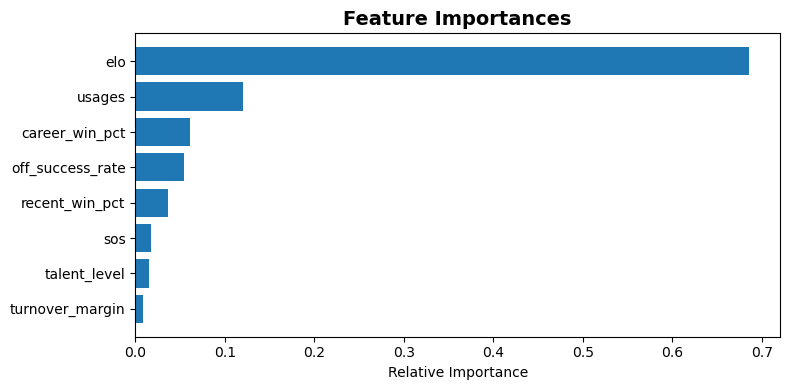

In [24]:
# Use my premade method for graphing feature importance
def graph_feature_importance(model, data):
    """
    model = trained model object from sklearn
    data = Usually X_train
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:] # Get top 10 most important features
    features = data.columns
    f, ax = plt.subplots(figsize=(8, 4))
    plt.title('Feature Importances', fontweight='bold', fontsize=14)
    plt.barh(range(len(indices)), importances[indices])#, color = colormap.colors)
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig('images/feature_imporances.png')
    plt.show()

graph_feature_importance(rf, X_feature_importance)

Let's setup a pipeline to scale our features

In [94]:
from sklearn.preprocessing import StandardScaler

# Scale data, retaining original column titles and structure. Scale on TRAINING data
scaler = StandardScaler()
# Fit and transform on TRAINING data
X_train_scl = pd.DataFrame(scaler.fit_transform(X_train.copy()), 
                            columns = X_train.columns)
# Now transform TEST data
X_test_scl = pd.DataFrame(scaler.transform(X_test.copy()),
                            columns = X_test.columns)

X_train_scl.head()

,elo,recent_win_pct,talent_level,turnover_margin,prev_win_pct,usages,off_success_rate,sos,career_win_pct
0,-1.510068,0.085843,-1.335420,-0.649366,-1.589183,0.364177,0.213572,1.316892,0.289885
1,-0.123588,-0.695501,-0.640320,-1.553399,0.437170,-0.171471,-1.030597,1.077786,0.190762
2,1.423792,0.965173,1.379251,0.642109,1.479295,-1.581846,0.902212,-0.356852,0.882436
3,-0.315299,-1.162491,-0.576135,-1.036809,-0.460215,-1.178882,0.115205,-0.091178,0.424468
4,-1.379979,-0.807246,-0.214990,-0.520219,-0.836538,0.531260,-0.716986,-1.313277,-0.268018


In [95]:
X_test_scl.head()

,elo,recent_win_pct,talent_level,turnover_margin,prev_win_pct,usages,off_success_rate,sos,career_win_pct
0,0.516589,-0.220381,-0.004413,-0.132776,0.437170,-1.213281,0.834517,-0.330284,0.177720
1,-2.235830,-1.244807,-0.378041,-0.261923,-0.836538,0.835941,-1.201582,1.848239,-0.274810
2,-0.089354,-1.127756,-0.850670,1.546142,-0.836538,0.364177,-0.845487,0.679275,-0.101996
3,-1.342321,-0.143603,-1.303463,-1.165956,-1.299704,0.270807,-0.704876,0.280765,-0.994227
4,0.811002,-0.970291,0.055778,2.062732,0.437170,-1.680130,0.112477,0.041659,0.562803


### Modeling
- Implement classical ML
- Use k fold cross validation

In [96]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

In [134]:
# Make kfold object. Set shuffle=True to maintain time ordering and prevent data leakage from ELO
kfold = TimeSeriesSplit(5)

mses = np.zeros((5,5))
i = 0
for i, (train_index, test_index) in enumerate(kfold.split(X_train)):

    X_tt, y_tt = X_train_scl.iloc[train_index], y_train.iloc[train_index]
    X_ho, y_ho = X_train_scl.iloc[test_index], y_train.iloc[test_index]
    X_ho_base, y_ho_base = X_train.iloc[test_index], y_train.iloc[test_index]

    # Baseline model, take previous winning percentage
    pred0 = X_ho_base['prev_win_pct']

    # Declare Models
    model1 = LinearRegression() # All features
    model2 = KNeighborsRegressor() 
    model3 = RandomForestRegressor()
    model4 = XGBRegressor() # Do XGB but with fine tuning

    # Train Models
    model1.fit(X_tt, y_tt)
    model2.fit(X_tt, y_tt)
    model3.fit(X_tt, y_tt)
    model4.fit(X_tt, y_tt)

    # add models to list
    models = ["Baseline", model1, model2, model3, model4]

    # Get predictions
    pred1 = model1.predict(X_ho)
    pred2 = model2.predict(X_ho)
    pred3 = model3.predict(X_ho)
    pred4 = model4.predict(X_ho)

    mses[0,i] = mean_squared_error(y_ho_base, pred0)
    mses[1,i] = mean_squared_error(y_ho, pred1)
    mses[2,i] = mean_squared_error(y_ho, pred2)
    mses[3,i] = mean_squared_error(y_ho, pred3)
    mses[4,i] = mean_squared_error(y_ho, pred4)
    

In [135]:
def percent_diff(a, b):
    return np.abs((a - b) / ((a + b) / 2)) * 100
def percent_improve(a,b):
    return np.abs((a-b) / b) * 100

In [153]:
# Get names of models
model_names = [type(model).__name__ for model in models]
# Set first to baseline
model_names[0] = 'Baseline Naive Forecast'

# Add mses to a list
avg_mses = np.mean(mses, axis=1)
pct_improve_mses = [percent_improve(m, np.mean(mses[0])) for m in np.mean(mses, axis=1)]
avg_rmses = np.sqrt(np.mean(mses, axis=1))
pct_improve_rmses = [percent_improve(m, np.sqrt(np.mean(mses[0]))) for m in np.sqrt(np.mean(mses, axis=1))]

# Add to a dataframe
performance_df = pd.DataFrame({'model': model_names, 'avg_mse': avg_mses, 'avg_rmse': avg_rmses, 
                               'pct_improve_mse': pct_improve_mses, 'pct_improve_rmse': pct_improve_rmses})
performance_df

,model,avg_mse,avg_rmse,pct_improve_mse,pct_improve_rmse
0,Baseline Naive Forecast,0.048402,0.220004,0.000000,0.000000
1,LinearRegression,0.030737,0.175319,36.497022,20.311244
2,KNeighborsRegressor,0.038067,0.195109,21.351520,11.316022
3,RandomForestRegressor,0.032943,0.181503,31.937845,17.500209
4,XGBRegressor,0.038238,0.195546,20.998344,11.117124


In [137]:
# Find the best model
best_model_num = np.argmin(np.mean(mses, axis=1))
print(f'Best Model: {best_model_num}')
print(f'Percent Improvement: {percent_improve(min(np.mean(mses, axis=1)), np.mean(mses[0]))}')

Best Model: 1
Percent Improvement: 36.49702228360844


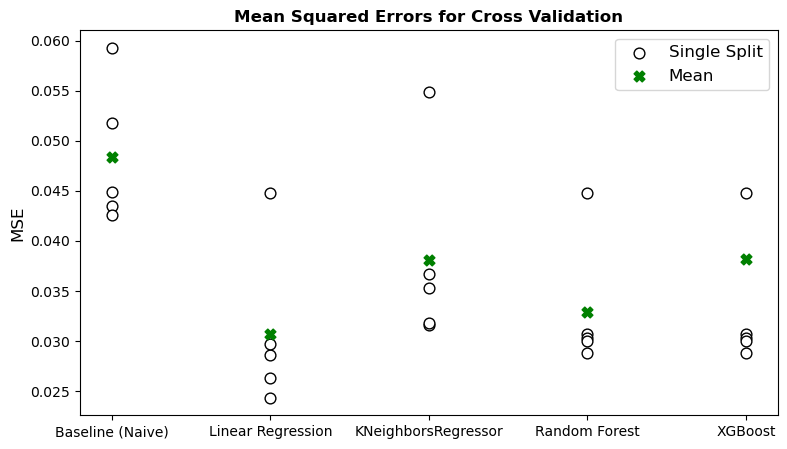

In [130]:
## From Erdos lecture, this figure will graphically compare the performance
plt.figure(figsize=(9,5))

plt.scatter(np.zeros(5), mses[0,:], s=60, c='white', edgecolor='black', label="Single Split")
plt.scatter(np.ones(5), mses[1,:], s=60, c='white', edgecolor='black')
plt.scatter(2*np.ones(5), mses[2,:], s=60, c='white', edgecolor='black')
plt.scatter(3*np.ones(5), mses[3,:], s=60, c='white', edgecolor='black')
plt.scatter(4*np.ones(5), mses[3,:], s=60, c='white', edgecolor='black')
plt.scatter([0,1,2,3,4], np.mean(mses, axis=1), s=60, c='g',marker='X',label="Mean")

plt.legend(fontsize=12)

plt.xticks([0,1,2,3, 4],["Baseline (Naive)", "Linear Regression", "KNeighborsRegressor", "Random Forest", "XGBoost"], fontsize=10)
plt.yticks(fontsize=10)
plt.title('Mean Squared Errors for Cross Validation', fontweight='bold')
plt.ylabel("MSE", fontsize=12)
plt.savefig('images/cross-val-mses.png')
plt.show()

### Testing the Model
- Take the best performing model and use for prediction

In [126]:
# Get the best model
best_model = models[best_model_num]

y_pred = best_model.predict(X_test_scl)
mse_test = mean_squared_error(y_pred, y_test)
print(f'Best Model MSE = {mse_test}')

Best Model MSE = 0.025275408331086584


To interpret the error, we did the following:
1. Multiply the win percentage by 12 season games and round to the nearest number of wins
2. Find the RMSE of the predicted vs. actual wins

In [67]:
print(f'RMSE of Best Model x 12 = {12*np.sqrt(mse_test)}')

RMSE of Best Model x 12 = 1.9077889819569847


Compared to the baseline model RMSE (multiply by 12 to get number of games)

In [78]:
y_pred_base = X_test['prev_win_pct']
mse_base = mean_squared_error(y_test, y_pred_base)
print(f'MSE of Baseline Model = {mse_base}')
print(f'RMSE of Baseline Model x 12 = {12*np.sqrt(mse_base)}')

MSE of Baseline Model = 0.036192618868255734
RMSE of Baseline Model x 12 = 2.282922932783502


So we see an improvement over the baseline of...

In [69]:
print(f' Percent Improvement of Best Model Over Baseline: {percent_diff(mse_test,mse_base):.4f}%')

 Percent Improvement of Best Model Over Baseline: 35.5216


In [158]:
test_performance_df = pd.DataFrame({'model': ['LinearRegression'], 
                                    'test_mse': [mse_test], 
                                    'test_rmse': [np.sqrt(mse_test)], 
                                    'pct_improve_mse': [percent_diff(mse_test, mse_base)],
                                    'pct_improve_rmse': [percent_diff(np.sqrt(mse_test), np.sqrt(mse_base))]
                                    })
test_performance_df

,model,test_mse,test_rmse,pct_improve_mse,pct_improve_rmse
0,LinearRegression,0.025275,0.158982,35.521591,17.903113


### Hyperparameter Tuning using XGBoost

In [35]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
    # Add more parameters as needed
}

### Deep Learning Methods
- LSTMs often used for time series

In [138]:
# Reshape data from (samples, features) to (samples, time steps, features)
X_train_scl_reshape = np.reshape(X_train_scl , (X_train_scl.shape[0], 1, X_train_scl.shape[1]))
X_test_scl_reshape = np.reshape(X_test_scl , (X_test_scl.shape[0], 1, X_test_scl.shape[1]))

In [139]:
BATCH_SIZE = 32
N_EPOCHS = 50
num_batches = len(X_train_scl) // BATCH_SIZE

In [140]:
# Make kfold object. Set shuffle=True to maintain time ordering and prevent data leakage from ELO
kfold = TimeSeriesSplit(5)

lstm_mses = []
histories = []
i = 0
for i, (train_index, test_index) in enumerate(kfold.split(X_train)):

    X_tt, y_tt = X_train_scl.iloc[train_index], y_train.iloc[train_index]
    X_ho, y_ho = X_train_scl.iloc[test_index], y_train.iloc[test_index]
    X_ho_base, y_ho_base = X_train.iloc[test_index], y_train.iloc[test_index]

    # Reshape data from (samples, features) to (samples, time steps, features)
    X_tt_reshape = np.reshape(X_tt , (X_tt.shape[0], 1, X_tt.shape[1]))
    X_ho_reshape = np.reshape(X_ho , (X_ho.shape[0], 1, X_ho.shape[1]))

    # Baseline model, take previous winning percentage
    pred0 = X_ho_base['prev_win_pct']

    # Declare and Compile Models
    model_lstm = Sequential([
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model_lstm.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=0)

    # Train and store history (which includes predictions)
    history = model_lstm.fit(X_tt_reshape, 
            y_tt, 
            epochs=N_EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_ho_reshape, y_ho),
            callbacks=[early_stop],
            verbose=0)
    histories.append(history)

    # Get mses
    lstm_mses.append(min(history.history['val_loss']))
    

In [142]:
# Print results
print(f"MSEs for Each Cross Val: {lstm_mses}")
print(f'Average MSE: {np.mean(lstm_mses)}')
print(f"Percent Improvement Over Baseline: {percent_diff(np.mean(lstm_mses), np.mean(mses[0]))}")

MSEs for Each Cross Val: [0.02863560989499092, 0.03303379565477371, 0.028962938115000725, 0.04525909200310707, 0.03267255052924156]
Average MSE: 0.0337127972394228
Percent Improvement Over Baseline: 35.77708273290916


In [154]:
# Add these cross val lstm results to our dataframe
new_row = pd.DataFrame({'model': ['LSTM'], 
                     'avg_mse': [np.mean(lstm_mses)], 
                     'avg_rmse': [np.sqrt(np.mean(lstm_mses))],
                     'pct_improve_mse': [percent_improve(np.mean(lstm_mses), np.mean(mses[0]))],
                     'pct_improve_rmse': [percent_improve(np.sqrt(np.mean(lstm_mses)), np.sqrt(np.mean(mses[0])))]
                    })

performance_df = pd.concat([performance_df, new_row], ignore_index=True)
performance_df

,model,avg_mse,avg_rmse,pct_improve_mse,pct_improve_rmse
0,Baseline Naive Forecast,0.048402,0.220004,0.000000,0.000000
1,LinearRegression,0.030737,0.175319,36.497022,20.311244
2,KNeighborsRegressor,0.038067,0.195109,21.351520,11.316022
3,RandomForestRegressor,0.032943,0.181503,31.937845,17.500209
4,XGBRegressor,0.038238,0.195546,20.998344,11.117124
5,LSTM,0.033713,0.183610,30.348228,16.542363


In [155]:
# Save the dataframe to markdown code
markdown_table = performance_df.to_markdown(index=False)

# Print or save the Markdown table string
print(markdown_table)
# Or save to a file
with open('out/cross_validation_performance.md', 'w') as f:
    f.write(markdown_table)

| model                   |   avg_mse |   avg_rmse |   pct_improve_mse |   pct_improve_rmse |
|:------------------------|----------:|-----------:|------------------:|-------------------:|
| Baseline Naive Forecast | 0.0484019 |   0.220004 |            0      |             0      |
| LinearRegression        | 0.0307367 |   0.175319 |           36.497  |            20.3112 |
| KNeighborsRegressor     | 0.0380674 |   0.195109 |           21.3515 |            11.316  |
| RandomForestRegressor   | 0.0329434 |   0.181503 |           31.9378 |            17.5002 |
| XGBRegressor            | 0.0382383 |   0.195546 |           20.9983 |            11.1171 |
| LSTM                    | 0.0337128 |   0.18361  |           30.3482 |            16.5424 |


In [41]:
# Get results for test set
y_pred = model_lstm.predict(X_test_scl_reshape)
lstm_error = mean_squared_error(y_pred, y_test)
print(f'LSTM Test MSE: {lstm_error}')

4/4 [==============================] - 1s 7ms/step
LSTM Test MSE: 0.024866087346538997


In [72]:
# Compare to baseline
percent_diff(lstm_error,mean_squared_error(y_test, y_pred_base))

37.100463550183385

/var/folders/70/g0t97b0x2r964_f_p7d3sgwc0000gn/T/ipykernel_29314/3215021690.py:11: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


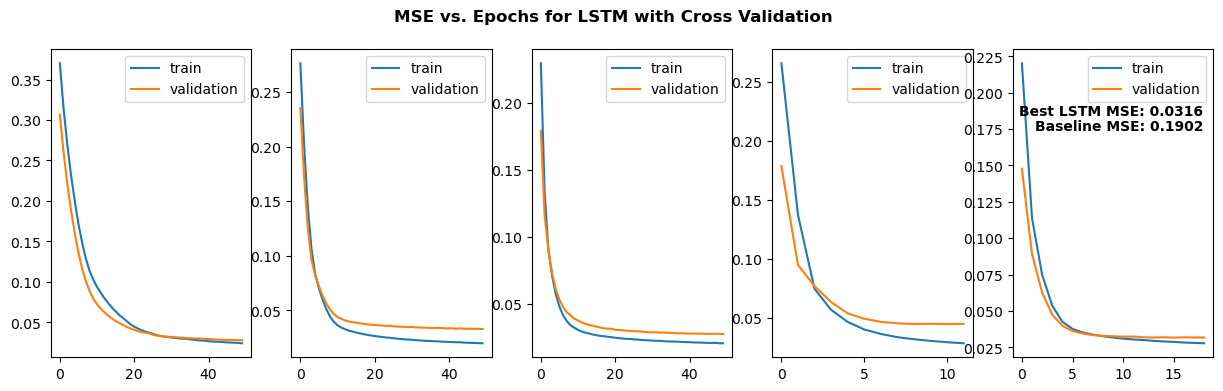

In [43]:
# Plot the loss history
fig, axes = plt.subplots(1,5, figsize=(15,4))
for i, history in enumerate(histories):
    axes[i].plot(history.history['loss'], label='train')
    axes[i].plot(history.history['val_loss'], label='validation')
    axes[i].text(0.95, 0.8, f"Best LSTM MSE: {min(history.history['val_loss']):.4f}", ha='right', va='center', transform=plt.gca().transAxes, fontweight='bold')
    axes[i].text(0.95, 0.75, f"Baseline MSE: {np.sqrt(mean_squared_error(y_test, y_pred_base)):.4f}", ha='right', va='center', transform=plt.gca().transAxes, fontweight='bold')
    axes[i].legend()

plt.suptitle('MSE vs. Epochs for LSTM with Cross Validation', fontweight='bold')
plt.tight_layout()
plt.savefig('images/lstm_loss.png')
plt.show()

#### LSTM w/o Cross Validation
- Cross validation, given our relatively short window of time for our data, is struggling with the 2020 season, where many teams didn't play or played abbreviated schedules, lots of players sitting out for the entire season or strings of games for covid, etc.

In [44]:
BATCH_SIZE = 32
N_EPOCHS = 50
num_batches = len(X_train_scl) // BATCH_SIZE

model = Sequential([
    LSTM(50, activation='relu'),
    Dense(1)
])

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train_scl_reshape, 
            y_train, 
            epochs=N_EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_scl_reshape, y_test),
            callbacks=[early_stop],
            verbose=0)
y_pred = model.predict(X_test_scl_reshape)

Epoch 25: early stopping
4/4 [==============================] - 0s 3ms/step


In [70]:
# Take the best val_loss convert into % difference with base model
best_mse = min(history.history['val_loss'])

lstm_percent_diff = percent_diff(best_mse,mean_squared_error(y_test, y_pred_base))
print(f'Improvement over baseline: {lstm_percent_diff:.2f}%')

Improvement over baseline: 40.68%


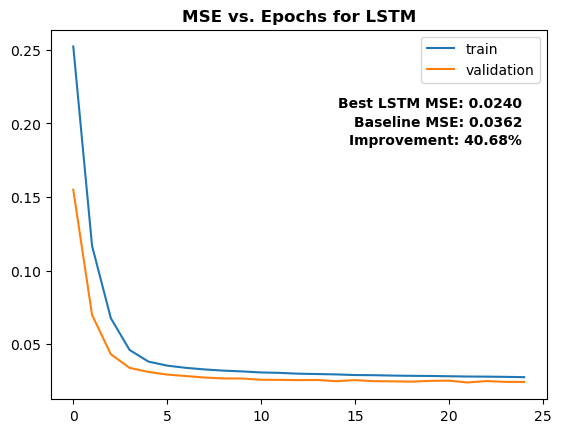

In [71]:
# Plot the loss history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('MSE vs. Epochs for LSTM', fontweight='bold')
plt.text(0.95, 0.8, f"Best LSTM MSE: {min(history.history['val_loss']):.4f}", ha='right', va='center', transform=plt.gca().transAxes, fontweight='bold')
plt.text(0.95, 0.75, f"Baseline MSE: {mean_squared_error(y_test, y_pred_base):.4f}", ha='right', va='center', transform=plt.gca().transAxes, fontweight='bold')
plt.text(0.95, 0.7, f"Improvement: {lstm_percent_diff:.2f}%", ha='right', va='center', transform=plt.gca().transAxes, fontweight='bold')
plt.legend()
plt.savefig('images/lstm_loss.png')
plt.show()

In [159]:
# Add to our test performance df since it did better
new_row_test = pd.DataFrame({'model': ['LSTM'], 
                                    'test_mse': [best_mse], 
                                    'test_rmse': [np.sqrt(best_mse)], 
                                    'pct_improve_mse': [percent_diff(best_mse, mse_base)],
                                    'pct_improve_rmse': [percent_diff(np.sqrt(best_mse), np.sqrt(mse_base))]
                                    })
test_performance_df = pd.concat([test_performance_df, new_row_test], ignore_index=True)
test_performance_df

,model,test_mse,test_rmse,pct_improve_mse,pct_improve_rmse
0,LinearRegression,0.025275,0.158982,35.521591,17.903113
1,LSTM,0.023959,0.154787,40.675638,20.552591


In [160]:
# Save the dataframe to markdown code
markdown_table_test = test_performance_df.to_markdown(index=False)

# Print or save the Markdown table string
print(markdown_table_test)
# Or save to a file
with open('out/test_set_performance.md', 'w') as f:
    f.write(markdown_table_test)

| model            |   test_mse |   test_rmse |   pct_improve_mse |   pct_improve_rmse |
|:-----------------|-----------:|------------:|------------------:|-------------------:|
| LinearRegression |  0.0252754 |    0.158982 |           35.5216 |            17.9031 |
| LSTM             |  0.0239591 |    0.154787 |           40.6756 |            20.5526 |
